In [9]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [10]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import pandas_to_fits, fits_to_pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Chandra/XMM with DESI 

,srcname_fin,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_sigma,csc_pos_r98,csc_FLUX_05_2,csc_flux_aper_sm_err,csc_likelihood,csc_likelihood_class,sep_ero_csc,sep_csc_desi,release,brickid,objid,ra,dec,desi_id,IDSRC_desi_id,ero_flux_05-20,ero_pos_r98,ero_pos_sigma_2d,ero_RA_fin,ero_DEC_fin,ero_DET_LIKE_0,csc_ero_flux_ratio
0,SRGe J105316.7+573551,2CXO J105316.7+573550,163.319906,57.597453,0.712676,0.711335,0.411369,1.150662,NaN,NaN,15055.956674,TRUE,0.970884,0.144735,9011,609950,3809,163.319852,57.597425,9011_609950_3809,SRGe J105316.7+573551_9011_609950_3809,1.327770e-13,2.276231,0.813768,163.319421,57.597379,2174.8645,NaN
1,SRGe J105335.1+572543,2CXO J105335.0+572541,163.395863,57.428329,0.740180,0.718313,0.421378,1.178657,NaN,NaN,5957.706781,TRUE,1.062877,0.241237,9011,609951,491,163.395958,57.428372,9011_609951_491,SRGe J105335.1+572543_9011_609951_491,7.887368e-14,2.442085,0.873062,163.396337,57.428477,1026.8735,NaN
2,SRGe J105432.1+580046,2CXO J105432.2+580047,163.634353,58.013174,0.856368,0.759133,0.467532,1.307756,0.0,1.382023e-14,654.613560,TRUE,1.697386,0.261635,9011,611496,691,163.634295,58.013108,9011_611496_691,SRGe J105432.1+580046_9011_611496_691,6.718623e-14,2.608968,0.932724,163.633625,58.012903,942.2203,0.0


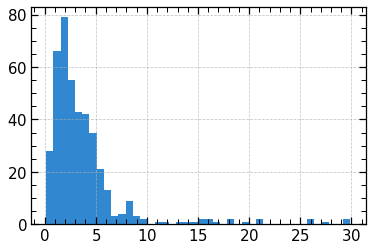

In [11]:
csc_ctps = pd.read_csv(data_path+'ero_csc_desi.csv')
plt.hist(csc_ctps.sep_ero_csc)
csc_ctps.head(3)

,srcname_fin,xmm_SRCID,xmm_SC_RA,xmm_SC_DEC,xmm_SC_POSERR,xmm_sigma,xmm_pos_r98,xmm_FLUX_05_2,xmm_FLUX_05_2_err,xmm_SC_DET_ML,xmm_SC_VAR_FLAG,xmm_SC_SUM_FLAG,xmm_SC_EXT_ML,xmm_SC_EXTENT,xmm_SC_EXT_ERR,xmm_SC_FVAR,xmm_SC_FVARERR,xmm_CONFUSED,sep_ero_xmm,sep_xmm_desi,release,brickid,objid,ra,dec,desi_id,IDSRC_desi_id,ero_flux_05-20,ero_pos_r98,ero_pos_sigma_2d,ero_RA_fin,ero_DEC_fin,ero_DET_LIKE_0,xmm_ero_flux_ratio
0,SRGe J104117.7+584929,205562112010003,160.324685,58.824762,0.817968,0.580060,1.622515,8.770400e-14,6.519681e-15,742.578,False,0,-2.27685,0.0,NaN,0.012697,1.426367,False,2.015272,0.975167,9011,613766,43,160.324219,58.824639,9011_613766_43,SRGe J104117.7+584929_9011_613766_43,1.817271e-13,2.166339,0.774481,160.323629,58.824642,3391.8890,0.482614
1,SRGe J103618.3+581246,205562110010001,159.076917,58.213093,0.568896,0.403431,1.128458,1.677284e-13,8.215893e-15,1899.140,False,0,-2.90832,0.0,NaN,0.087740,0.112042,False,1.987860,1.384893,9011,612250,2743,159.076381,58.212831,9011_612250_2743,SRGe J103618.3+581246_9011_612250_2743,1.704142e-13,2.166670,0.774599,159.076205,58.212688,3020.2393,0.984240
2,SRGe J105316.7+573551,201237001010003,163.319955,57.597429,0.077942,0.055272,0.154605,9.493300e-14,5.897774e-16,20363.300,False,1,-2.54092,0.0,NaN,0.306044,0.073647,False,1.045047,0.199473,9011,609950,3809,163.319852,57.597425,9011_609950_3809,SRGe J105316.7+573551_9011_609950_3809,1.327770e-13,2.276231,0.813768,163.319421,57.597379,2174.8645,0.714981


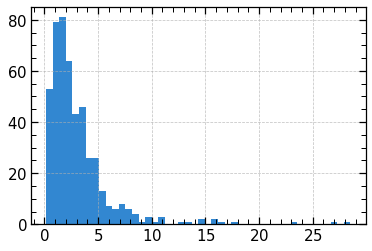

In [12]:
xmm_ctps = pd.read_csv(data_path+'ero_xmm_desi.csv')
plt.hist(xmm_ctps.sep_ero_xmm)
xmm_ctps.head(3)

flux ratio filter

In [13]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

distance filter

In [14]:
xmm_ctps = xmm_ctps.query('sep_ero_xmm < ero_pos_r98 ')[['srcname_fin','desi_id']]
csc_ctps = csc_ctps.query('sep_ero_csc < ero_pos_r98')[['srcname_fin','desi_id']]

In [15]:
finall_ctps = pd.concat([xmm_ctps, csc_ctps])
finall_ctps.sort_values(by='srcname_fin', inplace=True)

n_ctps = finall_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique())) #Number of XMM and Chandra CTPs per ero source
finall_ctps['n_desi'] = n_ctps

finall_ctps = finall_ctps[finall_ctps.n_desi == 1]
finall_ctps.drop_duplicates(subset='srcname_fin', inplace=True)
finall_ctps.rename(columns={'srcname_fin':'ID'}, inplace=True)
finall_ctps.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
#finall_ctps.ID = finall_ctps.ID.str.encode('utf-8')
#finall_ctps.desi_id_true_ctp = finall_ctps.desi_id_true_ctp.str.encode('utf-8')
finall_ctps.to_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')

finall_ctps

,ID,desi_id_true_ctp,n_desi
368,SRGe J103105.9+573747,9011_610714_1440,1
257,SRGe J103118.8+574434,9011_610714_1908,1
48,SRGe J103123.8+574309,9011_610714_2092,1
284,SRGe J103130.8+573932,9011_610714_2412,1
173,SRGe J103137.0+573159,9011_609939_1093,1
...,...,...,...
129,SRGe J110633.0+590313,9011_614527_1198,1
193,SRGe J110645.0+590331,9011_614527_1596,1
169,SRGe J110648.4+585514,9011_614527_1704,1
73,SRGe J110721.2+585635,9011_614527_2647,1


# Only X-ray companions for eROSITA

,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_sigma,csc_pos_r98,csc_flux_05_2,csc_flux_aper_sm_err,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_GroupID,csc_GroupSize,sep_ero_csc,ero2csc_flux_ratio
0,SRGe J110242.6+594120,165.677384,59.688978,1.420726e-13,2.736290,7.653812,211.181180,0.0,8.419194,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,1.244794,3.481875,2.196054e-13,2.554235e-14,629.754672,TRUE,False,NaN,1.0,2.779278,0.646945
1,SRGe J105316.7+573551,163.319421,57.597379,1.327770e-13,0.813768,2.276231,2174.864500,0.0,5.000000,2CXO J105316.7+573550,163.319906,57.597453,0.712676,0.711335,0.411369,1.150662,NaN,NaN,15055.956674,TRUE,False,NaN,1.0,0.970884,NaN
2,SRGe J105300.9+574208,163.253903,57.702143,1.266503e-13,0.816646,2.284281,2098.832300,0.0,5.000000,2CXO J105301.0+574208,163.254465,57.702249,0.726467,0.720211,0.417921,1.168988,NaN,NaN,381.913259,TRUE,False,NaN,1.0,1.147400,NaN
3,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,2CXO J104144.8+594258,160.436809,59.716113,6.180927,6.180927,3.571101,9.988904,1.493810e-13,4.562363e-14,104.364506,TRUE,False,NaN,1.0,2.516922,0.753176
4,SRGe J105429.0+575203,163.620843,57.867397,1.107308e-13,0.853295,2.386794,1758.452100,0.0,5.000000,2CXO J105429.1+575202,163.621560,57.867469,0.968371,0.812312,0.516377,1.444382,7.095109e-14,1.508598e-14,345.444575,TRUE,False,NaN,1.0,1.397154,1.560664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,SRGe J104341.0+590023,160.920944,59.006447,2.463644e-15,3.694459,10.333953,7.300827,0.0,11.367348,2CXO J104341.2+590021,160.921860,59.005939,1.300886,0.956513,0.659664,1.845178,1.203987e-15,5.701047e-16,47.269314,TRUE,False,NaN,1.0,2.495724,2.046239
559,SRGe J103413.7+581151,158.557276,58.197420,2.451287e-15,4.411703,12.340194,6.172582,0.0,13.574213,2CXO J103413.0+581151,158.554454,58.197617,2.691612,2.691612,1.555109,4.349873,2.721475e-15,1.999777e-15,13.379965,MARGINAL,False,NaN,1.0,5.400560,0.900720
560,SRGe J103429.8+575220,158.624361,57.872160,2.389110e-15,3.696288,10.339070,6.083099,0.0,11.372977,2CXO J103429.6+575217,158.623432,57.871404,0.825624,0.772921,0.462039,1.292394,6.410410e-15,1.610095e-15,159.997928,TRUE,False,NaN,1.0,3.250830,0.372692
561,SRGe J104730.2+584301,161.875925,58.716881,2.380455e-15,3.949338,11.046889,6.768798,0.0,12.151578,2CXO J104730.0+584301,161.875400,58.717085,1.497509,1.052945,0.747886,2.091949,4.601460e-15,1.391266e-15,108.524810,TRUE,False,NaN,1.0,1.225655,0.517326


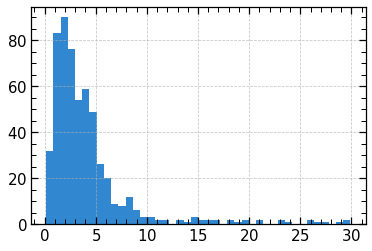

In [16]:
csc_ctps_xray = pd.read_csv(data_path+'csc_single_30sec_ero_reliable.csv')
plt.hist(csc_ctps_xray.sep_ero_csc)
csc_ctps_xray

,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,xmm_SRCID,xmm_SC_RA,xmm_SC_DEC,xmm_SC_POSERR,xmm_sigma,xmm_pos_r98,xmm_flux_05_2,xmm_flux_05_2_err,xmm_SC_DET_ML,xmm_SC_VAR_FLAG,xmm_SC_SUM_FLAG,xmm_SC_EXT_ML,xmm_SC_EXTENT,xmm_SC_EXT_ERR,xmm_SC_FVAR,xmm_SC_FVARERR,xmm_CONFUSED,xmm_GroupID,xmm_GroupSize,sep_ero_xmm,ero2xmm_flux_ratio
0,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,160.324685,58.824762,0.817968,0.580060,1.622515,8.770400e-14,6.519681e-15,742.5780,False,0,-2.276850,0.0,NaN,0.012697,1.426367,False,NaN,1.0,2.015272,2.072050
1,SRGe J103618.3+581246,159.076205,58.212688,1.704142e-13,0.774599,2.166670,3020.239300,0.0,5.000000,205562110010001,159.076917,58.213093,0.568896,0.403431,1.128458,1.677284e-13,8.215893e-15,1899.1400,False,0,-2.908320,0.0,NaN,0.087740,0.112042,False,NaN,1.0,1.987860,1.016013
2,SRGe J104827.7+593300,162.115455,59.550001,1.330816e-13,0.807671,2.259178,2195.570800,0.0,5.000000,205562114010004,162.114828,59.549727,0.715736,0.507563,1.419728,1.627813e-13,1.225398e-14,861.0710,False,0,-2.515260,0.0,NaN,0.159299,0.153481,False,NaN,1.0,1.510640,0.817548
3,SRGe J105316.7+573551,163.319421,57.597379,1.327770e-13,0.813768,2.276231,2174.864500,0.0,5.000000,201237001010003,163.319955,57.597429,0.077942,0.055272,0.154605,9.493300e-14,5.897774e-16,20363.3000,False,1,-2.540920,0.0,NaN,0.306044,0.073647,False,NaN,1.0,1.045047,1.398639
4,SRGe J105300.9+574208,163.253903,57.702143,1.266503e-13,0.816646,2.284281,2098.832300,0.0,5.000000,201237001010007,163.254014,57.702248,0.117241,0.083141,0.232558,1.417091e-13,1.175553e-15,7033.0900,False,1,-1.133790,0.0,NaN,0.438113,0.072698,False,NaN,1.0,0.433385,0.893734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,SRGe J104437.2+593126,161.154875,59.523770,2.422125e-15,3.094132,8.654750,6.360213,0.0,9.520225,205562129010017,161.156622,59.522768,1.410030,0.999920,2.796925,6.330540e-15,1.506756e-15,38.1722,NaN,0,-0.996143,0.0,NaN,NaN,NaN,False,NaN,1.0,4.815319,0.382610
736,SRGe J104614.0+585942,161.558429,58.995032,2.399448e-15,4.287310,11.992247,6.614729,0.0,13.191472,205541201010010,161.556281,58.994787,0.338216,0.239845,0.670883,9.524310e-15,4.703719e-16,487.1030,False,1,-1.433390,0.0,NaN,0.290614,0.116905,False,NaN,1.0,4.079490,0.251929
737,SRGe J103429.8+575220,158.624361,57.872160,2.389110e-15,3.696288,10.339070,6.083099,0.0,11.372977,203032602010056,158.622144,57.871823,0.835653,0.592601,1.657595,2.551120e-15,4.044796e-16,59.8393,NaN,0,-0.836594,0.0,NaN,NaN,NaN,False,NaN,1.0,4.414215,0.936495
738,SRGe J104939.7+590758,162.415404,59.132889,2.343887e-15,3.250494,9.092117,7.194517,0.0,10.001329,205562114010057,162.417503,59.134784,2.503000,1.774997,4.964931,3.125660e-15,1.575624e-15,12.2333,NaN,0,-0.554050,0.0,NaN,NaN,NaN,False,NaN,1.0,7.846452,0.749885


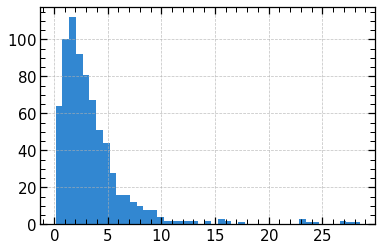

In [17]:
xmm_ctps_xray = pd.read_csv(data_path+'xmm_single_30sec_ero_reliable.csv')
plt.hist(xmm_ctps_xray.sep_ero_xmm)
xmm_ctps_xray

In [37]:
xmm_ctps_xray = xmm_ctps_xray[xmm_ctps_xray['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps_xray = xmm_ctps_xray[xmm_ctps_xray['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps_xray = csc_ctps_xray[csc_ctps_xray['csc_ero_flux_ratio'] <  5 ]
csc_ctps_xray = csc_ctps_xray[csc_ctps_xray['csc_ero_flux_ratio'] >  1/5 ]

KeyError: 'xmm_ero_flux_ratio'

In [ ]:
#xmm_ctps_xray = xmm_ctps_xray.query('xmm_SC_SUM_FLAG==0')
#xmm_ctps_xray = xmm_ctps_xray.query('sep_ero_xmm < ero_pos_r98 ')[['srcname_fin','desi_id']]
#csc_ctps_xray = csc_ctps_xray.query('sep_ero_csc < ero_pos_r98')[['srcname_fin','desi_id']]

In [54]:
finall_ctps_xray = pd.concat([xmm_ctps_xray, csc_ctps_xray])
finall_ctps_xray['n_xray'] = 1
finall_ctps_xray.sort_values(by='srcname_fin', inplace=True)

n_ctps = finall_ctps_xray.groupby('srcname_fin')['n_xray'].transform(lambda x: len(x)) #Number of XMM and Chandra CTPs per ero source
finall_ctps_xray['n_xray'] = n_ctps

#def apply_sep(df):
#    if df.sep_ero_csc.


#finall_ctps_xray['xray_sep'] = finall_ctps_xray.sep_ero_csc 
finall_ctps_xray

,srcname_fin,xmm_SRCID,xmm_SC_RA,xmm_SC_DEC,xmm_SC_POSERR,xmm_sigma,xmm_pos_r98,xmm_FLUX_05_2,xmm_FLUX_05_2_err,xmm_SC_DET_ML,xmm_SC_VAR_FLAG,xmm_SC_SUM_FLAG,xmm_SC_EXT_ML,xmm_SC_EXTENT,xmm_SC_EXT_ERR,xmm_SC_FVAR,xmm_SC_FVARERR,xmm_CONFUSED,xmm_GroupID,xmm_GroupSize,sep_ero_xmm,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_sigma,csc_pos_r98,csc_FLUX_05_2,csc_flux_aper_sm_err,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_GroupID,csc_GroupSize,sep_ero_csc,n_xray
479,SRGe J103105.9+573747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J103105.7+573749,157.773870,57.630436,2.311181,1.299491,1.083224,3.029941,2.116953e-15,1.016257e-15,29.913404,TRUE,False,NaN,1.0,2.430322,1
332,SRGe J103118.8+574434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J103118.6+574435,157.827805,57.743201,5.567843,3.681910,2.727050,7.627967,2.228575e-15,1.418991e-15,21.474961,MARGINAL,False,NaN,1.0,1.914688,1
394,SRGe J103121.9+573134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J103121.9+573134,157.841331,57.526115,1.677846,1.161206,0.833616,2.331750,3.862979e-15,1.555860e-15,85.236355,TRUE,False,NaN,1.0,0.504317,1
61,SRGe J103123.8+574309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J103123.5+574310,157.848084,57.719446,0.982539,0.834665,0.526690,1.473232,1.745068e-14,2.302311e-15,357.109000,TRUE,False,NaN,1.0,2.218144,1
368,SRGe J103130.8+573932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J103131.1+573934,157.879875,57.659663,0.848806,0.775642,0.469747,1.313953,1.157824e-14,2.247873e-15,341.311200,TRUE,False,NaN,1.0,3.683502,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,SRGe J110640.1+590926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J110639.5+590921,166.664847,59.156094,5.808105,4.434497,2.985379,8.350551,6.011799e-15,3.822612e-15,34.026838,TRUE,False,NaN,1.0,5.410228,1
247,SRGe J110645.0+590331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J110645.0+590329,166.687608,59.058260,1.938587,1.891941,1.106648,3.095459,1.045393e-14,3.239379e-15,89.000033,TRUE,False,NaN,1.0,1.497043,1
221,SRGe J110648.4+585514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J110648.4+585516,166.701886,58.921243,1.473742,1.121013,0.756469,2.115956,1.355708e-14,3.454481e-15,127.715611,TRUE,False,NaN,1.0,2.172300,1
90,SRGe J110721.2+585635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J110720.1+585633,166.833933,58.942636,2.337821,1.459983,1.126039,3.149699,2.975047e-14,1.474811e-14,188.944618,TRUE,False,NaN,1.0,8.518309,1


In [53]:
len(finall_ctps_xray.query("~sep_ero_csc.isna()"))
len(finall_ctps_xray.query("sep_ero_xmm.isna() & ~sep_ero_csc.isna()"))

563

In [47]:
finall_ctps_xray[finall_ctps_xray.n_xray==2][['srcname_fin', 'sep_ero_xmm','sep_ero_csc']].head(20)

,srcname_fin,sep_ero_xmm,sep_ero_csc
499,SRGe J103206.5+574428,5.297516,NaN
323,SRGe J103206.5+574428,NaN,5.660549
543,SRGe J103206.9+574544,4.379941,NaN
359,SRGe J103206.9+574544,NaN,3.889999
19,SRGe J103216.0+574927,0.486338,NaN
8,SRGe J103216.0+574927,NaN,0.755213
437,SRGe J103217.9+573836,NaN,6.134779
611,SRGe J103217.9+573836,6.641851,NaN
339,SRGe J103228.7+573456,3.725221,NaN
200,SRGe J103228.7+573456,NaN,1.997162


In [ ]:
finall_ctps_xray = pd.concat([xmm_ctps_xray, csc_ctps_xray])
finall_ctps_xray['n_xray'] = 1
finall_ctps_xray.sort_values(by='srcname_fin', inplace=True)

n_ctps = finall_ctps_xray.groupby('srcname_fin')['tmp_col'].transform(lambda x: len(x.unique())) #Number of XMM and Chandra CTPs per ero source
finall_ctps_xray['n_xray'] = n_ctps

finall_ctps_xray = finall_ctps_xray[finall_ctps_xray.n_desi == 1]
finall_ctps_xray.drop_duplicates(subset='srcname_fin', inplace=True)
finall_ctps_xray.rename(columns={'srcname_fin':'ID'}, inplace=True)
finall_ctps_xray.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
#finall_ctps_xray.ID = finall_ctps_xray.ID.str.encode('utf-8')
#finall_ctps_xray.desi_id_true_ctp = finall_ctps_xray.desi_id_true_ctp.str.encode('utf-8')
finall_ctps_xray.to_pickle(data_path+'x_ray_validation_ctps_ero_lh.pkl')

finall_ctps_xray